##Assignment II - NLP: Seinfeld or Friends

Team members: Guy Maoz, Itay Shnaider & Asaf Biniamini

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


# Import the data

In [ ]:
# Load the dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/test.csv')

# Display the first few rows to understand the data structure
train_df.head()

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13


# Explorization

In [ ]:
# Basic EDA
eda_summary = {
    'total_entries': train_df.shape[0],
    'missing_values': train_df.isnull().sum(),
    'unique_characters': train_df['Character'].nunique(),
    'unique_episodes': train_df['Episode'].nunique(),
    'show_distribution': train_df['Show'].value_counts(),
    'average_dialogue_length': train_df['Dialogue_length'].mean(),
    'median_dialogue_length': train_df['Dialogue_length'].median(),
    'max_dialogue_length': train_df['Dialogue_length'].max(),
    'min_dialogue_length': train_df['Dialogue_length'].min()
}

eda_summary


{'total_entries': 70405,
 'missing_values': Dialogue           0
 Character          0
 Episode            0
 Show               0
 Dialogue_length    0
 dtype: int64,
 'unique_characters': 10,
 'unique_episodes': 398,
 'show_distribution': Friends     39092
 Seinfeld    31313
 Name: Show, dtype: int64,
 'average_dialogue_length': 11.002130530502095,
 'median_dialogue_length': 8.0,
 'max_dialogue_length': 363,
 'min_dialogue_length': 1}

The dataset contains:



*  70,405 total entries with no missing values across all columns.
*  10 unique characters have been identified in the dataset.
*  Dialogues are spread across 398 unique episodes.
*  The distribution of dialogues between the shows is 39,092 for Friends and 31,313 for Seinfeld.
*   The average length of dialogue is approximately 11 words, with a median length of 8 words. This indicates that the majority of dialogues are quite short, but there are longer dialogues that increase the average.
*   The longest dialogue consists of 363 words, and the shortest consists of just 1 word.









Now, let's visualize the distribution of dialogue lengths and the number of dialogues per character to gain further insights. This will help us understand if any preprocessing steps such as removing outliers or balancing the dataset might be necessary.

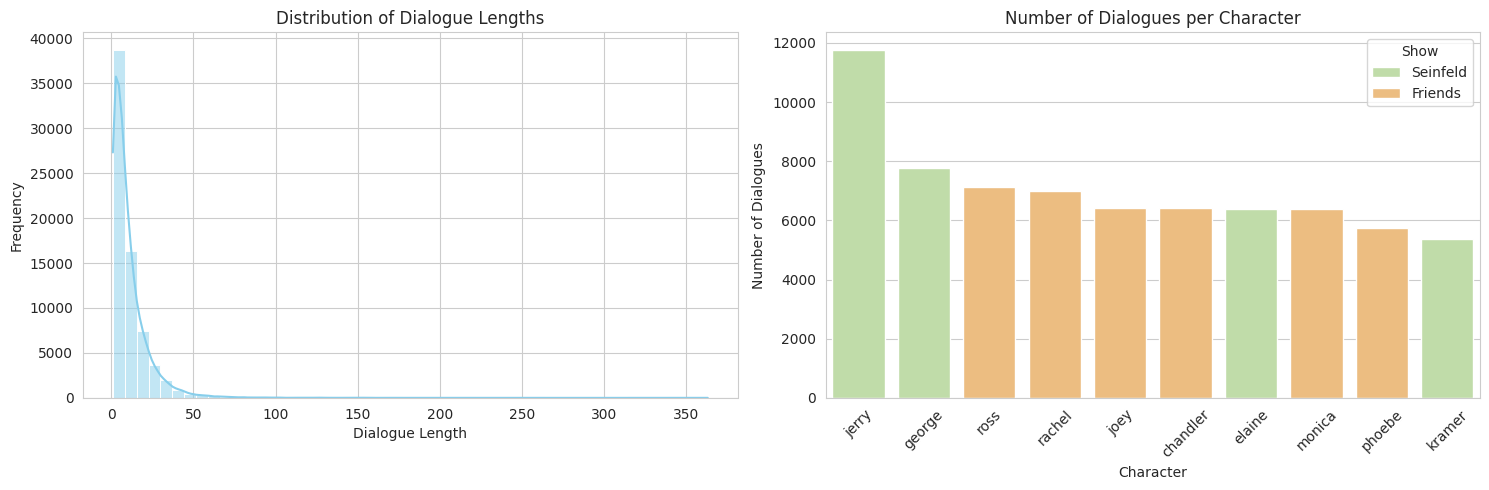

In [ ]:
sns.set_style("whitegrid")

# Distribution of dialogue lengths
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sns.histplot(train_df['Dialogue_length'], bins=50, kde=True, color='skyblue')  # Added color
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Dialogue Length')
plt.ylabel('Frequency')

# Number of dialogues per character
plt.subplot(1,2,2)
colors = sns.color_palette('Spectral', n_colors=train_df['Show'].nunique())

show_colors = {show: colors[i] for i, show in enumerate(train_df['Show'].unique())}

character_show_df = train_df.groupby(['Character', 'Show']).size().reset_index(name='counts')
character_show_df_sorted = character_show_df.sort_values('counts', ascending=False)


sns.barplot(x='Character', y='counts', hue='Show', data=character_show_df_sorted,
            palette=show_colors)
plt.title('Number of Dialogues per Character')
plt.xlabel('Character')
plt.ylabel('Number of Dialogues')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The left graph shows the distribution of dialogue lengths across all episodes. Most dialogues are relatively short, with lengths clustering around the lower end of the scale. However, there's a long tail indicating some very long dialogues.

The right graph illustrates the number of dialogues per character. This indicates how frequently each character speaks within the dataset. The distribution seems varied among characters, suggesting that some characters speak more often than others, which could influence the model's learning if not addressed properly.

# Pre Processing

Let's start with the first step, text cleaning: We will clean the 'Dialogue' text by removing special characters, numbers, and unnecessary punctuation. This step aims to standardize the text, making it easier for the model to learn from it.

## Cleaning text

In [ ]:
# Function to clean the dialogue text
def pre_process_clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase to maintain consistency
    text = text.lower().strip()
    return text

# Apply the cleaning function to the Dialogue column
train_df['Cleaned_Dialogue'] = train_df['Dialogue'].apply(pre_process_clean_text)

# Display the first few rows to verify the cleaning
train_df[['Dialogue', 'Cleaned_Dialogue']].head()


,Dialogue,Cleaned_Dialogue
0,Hey.,hey
1,(to Joey) Are you gonna be embarrassed going ...,to joey are you gonna be embarrassed going up ...
2,"Me? No no no, you. You're gonna tell him. I'm ...",me no no no you youre gonna tell him im not go...
3,Alright you guys are off to party number one ...,alright you guys are off to party number one u...
4,Am I? Or am I so sane that you just blew your ...,am i or am i so sane that you just blew your mind


In the displayed table, we observe the cleaned data post-implementation. For instance, in the first dialogue, brackets are removed. Dialogues 2 and 4 showcase the elimination of question marks. This preprocessing step aims to enhance the quality and uniformity of the text data for subsequent analysis or modeling. <br>
Next, we'll address the outlier dialogues. Given the distribution we observed earlier, we'll remove dialogues longer than a 100 words.


## Removing Outliers


Following initial data exploration, a dialogue length threshold of 100 words is established. Given that a substantial majority of dialogues fall below this threshold, we opt to remove outliers with lengths exceeding 100 words from the dataset. This step streamlines the data, ensuring a more consistent and manageable set for subsequent analysis.

In [ ]:
# Our threshold for outliers
threshold = 100

# Count the number of words in the cleaned dialogues
train_df['Cleaned_Dialogue_Length'] = train_df['Cleaned_Dialogue'].apply(lambda x: len(x.split()))

# Remove dialogues longer than the threshold
filtered_df = train_df[train_df['Cleaned_Dialogue_Length'] <= threshold]

# Compare the original and filtered dataset sizes
original_size = train_df.shape[0]
filtered_size = filtered_df.shape[0]
outliers_removed = original_size - filtered_size

original_size, filtered_size, outliers_removed


(70405, 70289, 116)

After removing dialogues longer than 100 words, the dataset size decreased from 70,405 to 70,289 entries, with 116 outliers removed. This step helps in mitigating the potential skew caused by unusually long dialogues.

## Removing Stop Words

Let's see our example before removing the stop words

In [ ]:
filtered_df.iloc[1,5]

'to joey are you gonna be embarrassed going up there having nothing prepared'

In [ ]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Removing the stopwords
tqdm.pandas()

def pre_process_remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply function on review column
filtered_df['Cleaned_Dialogue'] = filtered_df['Cleaned_Dialogue'].progress_apply(pre_process_remove_stopwords)

  0%|          | 0/70289 [00:00<?, ?it/s]

<ipython-input-9-e8f334f409d0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cleaned_Dialogue'] = filtered_df['Cleaned_Dialogue'].progress_apply(pre_process_remove_stopwords)


Let's check our example after removing the stop words:

In [ ]:
filtered_df.iloc[1,5]

'joey gonna embarrassed going nothing prepared'

As we can see in the example, words like "are," "you," and "having" are taken out, making the text more concise. This helps in focusing on the essential meaning of the dialogue, disregarding unnecessary words.

## Stemming

Next, we apply stemming to the "Cleaned_Dialogue" column using the NLTK Porter stemming algorithm. This step involves reducing words to their base forms, facilitating more efficient text analysis by consolidating variations of the same word and simplifying feature extraction for downstream tasks.

In [ ]:
# Stemming the text
def pre_process_simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# Apply function on Cleaned_Dialogue column
filtered_df['Cleaned_Dialogue'] = filtered_df['Cleaned_Dialogue'].progress_apply(pre_process_simple_stemmer)

  0%|          | 0/70289 [00:00<?, ?it/s]

<ipython-input-11-5fc2cebbd7e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cleaned_Dialogue'] = filtered_df['Cleaned_Dialogue'].progress_apply(pre_process_simple_stemmer)


And Let's watch the result on our example:

In [ ]:
filtered_df.iloc[1,5]

'joey gonna embarrass go noth prepar'

We can see in the example that the dialogue undergoes a further transformation. Words like "embarrassed" and "prepared" are reduced to their root form ("embarrass" and "prepar"), resulting in a more streamlined and normalized representation. This process aids in simplifying the text, consolidating related words, and preparing the data for analysis or modeling by focusing on the core meaning of the words.

## Balances the labeled data

Now, we'll check the balance between the two shows in the dataset and apply a balancing technique if necessary.

In [ ]:
# Check the balance between the two shows
show_distribution = filtered_df['Show'].value_counts()
show_distribution


Friends     39054
Seinfeld    31235
Name: Show, dtype: int64

The dataset contains 39,054 dialogues from "Friends" and 31,235 dialogues from "Seinfeld". While there is some imbalance, it is not extremely severe. However, to ensure optimal model performance, given the relatively close numbers, we choose oversampling the "Seinfeld" dialogues slightly.

(Oversampling: Increase the number of instances in the underrepresented class by duplicating them.)


In [ ]:
def pre_process_balanced_distrubition(df):
    # Separate the dataset based on the shows
    df_friends = df[df['Show'] == 'Friends']
    df_seinfeld = df[df['Show'] == 'Seinfeld']

    # Oversample the Seinfeld dialogues
    df_seinfeld_oversampled = resample(df_seinfeld,
                                    replace=True,     # sample with replacement
                                    n_samples=len(df_friends),    # to match number in Friends class
                                    random_state=123) # reproducible results

    # Combine the oversampled Seinfeld dialogues with the Friends dialogues
    balanced_df = pd.concat([df_friends, df_seinfeld_oversampled])

    # Check the new balance between the two shows
    balanced_distribution = balanced_df['Show'].value_counts()
    balanced_distribution

    return balanced_df

In [ ]:
balanced_df = pre_process_balanced_distrubition(filtered_df)

The dataset is now perfectly balanced, with 39,054 dialogues from each show. This balanced dataset should help in training a more fair and unbiased model.

## Tokenization and Vectorization

In this  section, we perform tokenization and vectorization on our balanced TV show dialogue dataset. Tokenization converts text into individual elements (tokens), typically words, a crucial step in preparing text data for machine learning models. Following tokenization, we employ sequence padding using TensorFlow's Keras API to ensure consistent sequence lengths. This uniformity is vital for neural networks that expect standardized input dimensions. The process involves initializing a tokenizer, mapping words to integers, converting texts to integer sequences, and padding them for uniformity. The result is a numerical representation of our text data, primed for deep learning applications.

In [ ]:
# Attempting tokenization and vectorization with the balanced dataset
try:

    # Initialize the tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(balanced_df['Cleaned_Dialogue'])

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(balanced_df['Cleaned_Dialogue'])

    # Pad the sequences to have the same length
    max_length = max([len(seq) for seq in sequences])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Output the shape of the padded sequences and the tokenizer's word index
    print(padded_sequences.shape, len(tokenizer.word_index))
except ModuleNotFoundError:
    # If TensorFlow is still not available, inform the user
    print('TensorFlow is still not available in this environment.')


(78108, 62) 16036


With the tokenization and vectorization successfully executed, our text data is now appropriately formatted for neural network training.

## Labeling

First, we need to encode our target variable 'Show' into a binary format. We'll use LabelEncoder from scikit-learn for this purpose. The labels will be transformed such that 'Friends' might be encoded as 0, and 'Seinfeld' as 1.


In [ ]:
# Initialize and fit the label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(balanced_df['Show'])

Next, we split our dataset into training and validation sets. This is crucial for assessing our model's performance and ensuring it generalizes well beyond the training data.

In [ ]:
# Split the data: 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)


# Define the model


Our model for text classification features an embedding layer, a 1D convolutional layer with ReLU activation, flattening, a dense layer with L2 regularization, dropout for regularization, and a final dense layer with sigmoid activation for binary classification. Adjustments, like regularization strength and dropout rate, can be made for customization.

In [ ]:

# Adjust these values as needed
L2_REGULARIZATION = 0.001
DROPOUT_RATE = 0.5

# Define the model with regularization and dropout
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length),
    Conv1D(8, 3, padding='same', activation='relu'),
    Flatten(),
    Dense(10, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])


Before training, we need to compile our model with an optimizer, a loss function, and a metric to monitor.
We added early stopping and reduce learning rate call backs to improve the training process. they are changing the training process so it will now automatically stop if the validation loss doesn't improve for 3 epochs,
and the learning rate will reduce if the validation loss doesn't improve for 2 epochs.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Introduce EarlyStopping and ReduceLROnPlateau for better training control
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 62, 100)           1603700   
                                                                 
 conv1d (Conv1D)             (None, 62, 8)             2408      
                                                                 
 flatten (Flatten)           (None, 496)               0         
                                                                 
 dense (Dense)               (None, 10)                4970      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1611089 (6.15 MB)
Trainable params: 161108

Finally, we fit the model on our training data while validating its performance on the validation set

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/10
1953/1953 [==============================] - 35s 16ms/step - loss: 0.5579 - accuracy: 0.6958 - val_loss: 0.4784 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 2/10
1953/1953 [==============================] - 11s 6ms/step - loss: 0.4689 - accuracy: 0.7668 - val_loss: 0.4599 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 3/10
1953/1953 [==============================] - 10s 5ms/step - loss: 0.4249 - accuracy: 0.7926 - val_loss: 0.4556 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 4/10
1953/1953 [==============================] - 9s 5ms/step - loss: 0.3934 - accuracy: 0.8114 - val_loss: 0.4653 - val_accuracy: 0.7724 - lr: 0.0010
Epoch 5/10
1953/1953 [==============================] - 10s 5ms/step - loss: 0.3624 - accuracy: 0.8279 - val_loss: 0.4855 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 6/10
1953/1953 [==============================] - 10s 5ms/step - loss: 0.3252 - accuracy: 0.8485 - val_loss: 0.4949 - val_accuracy: 0.7779 - lr: 1.0000e-04


In [ ]:
# Save the number of epochs and embedding dimension for the summary csv
num_epochs = len(history.history['loss'])
embedding_dimension = model.layers[0].output_dim

print("Number of Epochs:", num_epochs)
print("Embedding Dimension:", embedding_dimension)

Number of Epochs: 6
Embedding Dimension: 100


# Implementing on the test data

Next, we'll apply the same preprocessing steps used on the training data to the test data.

In [ ]:
test_df['Cleaned_Dialogue'] = test_df['Dialogue'].apply(pre_process_clean_text)

# Count the number of words in the cleaned dialogues
test_df['Cleaned_Dialogue_Length'] = test_df['Cleaned_Dialogue'].apply(lambda x: len(x.split()))
# Remove dialogues longer than the threshold
test_df = test_df[test_df['Cleaned_Dialogue_Length'] <= threshold]

test_df['Cleaned_Dialogue'] = test_df['Cleaned_Dialogue'].progress_apply(pre_process_remove_stopwords)

test_df['Cleaned_Dialogue'] = test_df['Cleaned_Dialogue'].progress_apply(pre_process_simple_stemmer)


# Assuming 'tokenizer' is available from previous steps
test_sequences = tokenizer.texts_to_sequences(test_df['Cleaned_Dialogue'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Assuming 'label_encoder' is available from previous steps
y_test = label_encoder.transform(test_df['Show'])


  0%|          | 0/4217 [00:00<?, ?it/s]

  0%|          | 0/4217 [00:00<?, ?it/s]

# Evaluating the model

In [ ]:
# Make predictions on the train data
y_train_pred_prob = model.predict(X_train)
y_train_pred = [1 if prob > 0.5 else 0 for prob in y_train_pred_prob]  # Convert probabilities to class labels

# Make predictions on the test data
y_test_pred_prob = model.predict(test_padded_sequences)
y_test_pred = [1 if prob > 0.5 else 0 for prob in y_test_pred_prob]  # Convert probabilities to class labels


132/132 [==============================] - 0s 2ms/step


In [ ]:
# Calculate Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Train Accuracy: {train_accuracy * 100:.2f}% \n')

# Calculate Precision
test_precision = precision_score(y_test, y_test_pred)
print(f'Test Precision: {test_precision * 100:.2f}%')
train_precision = precision_score(y_train, y_train_pred)
print(f'Train Precision: {train_precision * 100:.2f}% \n')

# Calculate Recall
test_recall = recall_score(y_test, y_test_pred)
print(f'Test Recall: {test_recall * 100:.2f}%')
train_recall = recall_score(y_train, y_train_pred)
print(f'Train Recall: {train_recall * 100:.2f}% \n')

# Calculate F1 Score
test_f1 = f1_score(y_test, y_test_pred)
print(f'Test F1 Score: {test_f1 * 100:.2f}%')
train_f1 = f1_score(y_train, y_train_pred)
print(f'Train F1 Score: {train_f1 * 100:.2f}%\n')


Test Accuracy: 83.21%
Train Accuracy: 83.86% 

Test Precision: 78.95%
Train Precision: 79.99% 

Test Recall: 77.21%
Train Recall: 90.29% 

Test F1 Score: 78.07%
Train F1 Score: 84.83%



Here’s what each line does:

- **Accuracy**: Compares the predicted labels (`y_pred`) with the true labels (`y_test`) and computes the proportion of correct predictions over all predictions.
- **Precision**: Measures the accuracy of positive predictions. It's calculated as the number of true positives divided by the number of all positive predictions (true positives + false positives).
- **Recall**: Measures the ability of the classifier to find all the positive samples. It's calculated as the number of true positives divided by the number of all actual positives (true positives + false negatives).
- **F1 Score**: Provides a single score that balances both the precision and the recall in one number. It's particularly useful if you have an uneven class distribution, as it seeks a balance between precision and recall.


# Analyzing the Results

Analyzing Results by Character:


In [ ]:
# Results dictionary
results = {}

# List of characters to analyze
characters = ['jerry', 'george', 'elaine', 'kramer', 'ross', 'rachel', 'chandler', 'monica', 'joey', 'phoebe']

for character in characters:
    # Filter by character
    character_df = test_df[test_df['Character'].str.lower() == character]

    # Continue only if there are lines for the character
    if not character_df.empty:
        # Preprocess the dialogues
        character_cleaned_dialogues = character_df['Cleaned_Dialogue'].apply(pre_process_clean_text)
        character_sequences = tokenizer.texts_to_sequences(character_cleaned_dialogues)
        character_padded_sequences = pad_sequences(character_sequences, maxlen=max_length, padding='post')

        # Predict and evaluate
        character_y_true = label_encoder.transform(character_df['Show'])
        character_y_pred_prob = model.predict(character_padded_sequences)
        character_y_pred = [1 if prob > 0.5 else 0 for prob in character_y_pred_prob.flatten()]

        # Calculate accuracy for this character
        character_accuracy = accuracy_score(character_y_true, character_y_pred)
        results[character] = character_accuracy

# Display the results
for character, accuracy in results.items():
  print(f"{character.capitalize()}: {accuracy * 100:.2f}%")


13/13 [==============================] - 0s 5ms/step
Jerry: 78.98%
George: 77.22%
Elaine: 72.26%
Kramer: 78.64%
Ross: 88.58%
Rachel: 86.98%
Chandler: 84.39%
Monica: 88.68%
Joey: 85.93%
Phoebe: 87.50%


Now let's see it on a graph

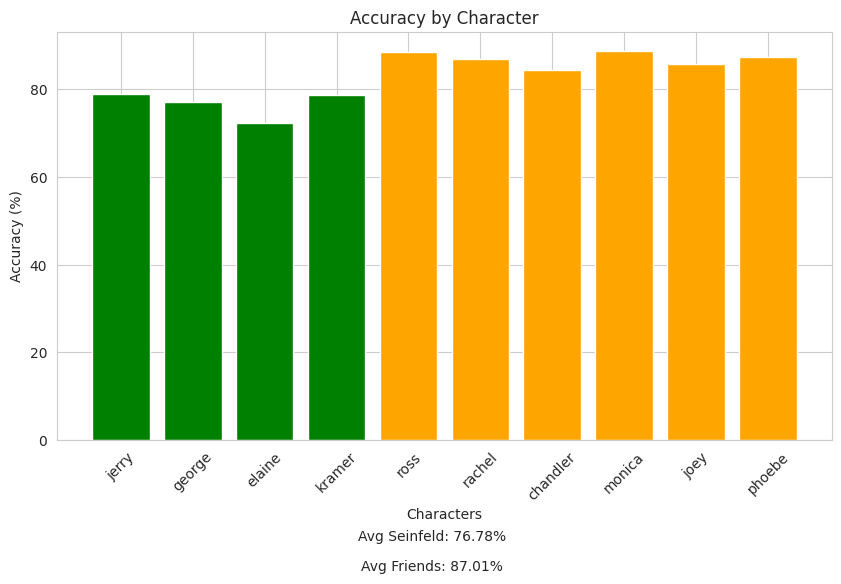

In [ ]:
# Character names and their accuracies
names = list(results.keys())
values = [accuracy * 100 for accuracy in results.values()]

# Define shows and their characters
shows = {
    'Seinfeld': ['jerry', 'george', 'elaine', 'kramer'],
    'Friends': ['ross', 'rachel', 'chandler', 'monica', 'joey', 'phoebe']
}

# Define colors for each show
color_map = {
    'jerry': 'green', 'george': 'green', 'elaine': 'green', 'kramer': 'green',  # Colors for Seinfeld characters
    'ross': 'orange', 'rachel': 'orange', 'chandler': 'orange', 'monica': 'orange', 'joey': 'orange', 'phoebe': 'orange'  # Colors for Friends characters
}

# Assign colors to each character
colors = [color_map[name] for name in names]

# Calculate average accuracy for each show
avg_accuracies = {}
for show, chars in shows.items():
    avg_accuracies[show] = np.mean([results[char] * 100 for char in chars if char in results])

# Creating the bar plot with adjusted margins
plt.figure(figsize=(10, 6))
plt.subplots_adjust(bottom=0.2)
bars = plt.bar(names, values, color=colors)
plt.xlabel('Characters')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Character')
plt.xticks(rotation=45)

# Add average accuracy annotations outside the plot
for i, (show, avg_accuracy) in enumerate(avg_accuracies.items()):
    plt.figtext(0.5, 0.05 - (i * 0.05), f'Avg {show}: {avg_accuracy:.2f}%', ha='center', va='top')

plt.show()


The model seems to perform well across various characters from both "Seinfeld" and "Friends."
Characters from "Friends" generally have higher accuracies compared to those from "Seinfeld." <br>
The reason why the model might do better on "Friends" characters than on "Seinfeld" characters is likely because we have a lot more examples from the "Friends" show. This unequal amount of data can influence the model's predictions, making it more familiar with the characters from the larger dataset.








# Summary

In [ ]:
model_details = {
    'Test Set Accuracy': [test_accuracy],
    'Train Set Accuracy': [train_accuracy],
    'Number of Trainable Parameters': [model.count_params()],
    'Number of Layers': [len(model.layers)],
    'Regularization Methods': ['L2, Dropout'],
    'Number of Epochs': [num_epochs],
    'Choice of Loss Function': ['binary_crossentropy'],
    'Choice of Optimizer': ['Adam'],
    'Embedding Dimension': [embedding_dimension]
}

exercise3_df = pd.DataFrame(model_details)

csv_file_name = 'exercise3.csv'

exercise3_df.to_csv(csv_file_name, index=False)



In [ ]:
exercise3_df

,Test Set Accuracy,Train Set Accuracy,Number of Trainable Parameters,Number of Layers,Regularization Methods,Number of Epochs,Choice of Loss Function,Choice of Optimizer,Embedding Dimension
0,0.832108,0.838556,1611089,6,"L2, Dropout",6,binary_crossentropy,Adam,100
